In [44]:
import matplotlib
matplotlib.use('Agg')

from datascience import Table
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
plt.style.use('fivethirtyeight')

In [53]:
patients = Table.read_table('/home/jovyan/work/datasets/breast-cancer-wisconsin.csv', dtype=np.int32).drop('id')
patients


thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
5,1,1,1,2,1,3,1,1,2
5,4,4,5,7,10,3,2,1,2
3,1,1,1,2,2,3,1,1,2
6,8,8,1,3,4,3,7,1,2
4,1,1,3,2,1,3,1,1,2
8,10,10,8,7,10,9,7,1,4
1,1,1,1,2,10,3,1,1,2
2,1,2,1,2,1,3,1,1,2
2,1,1,1,2,1,1,1,5,2
4,2,1,1,2,1,2,1,1,2


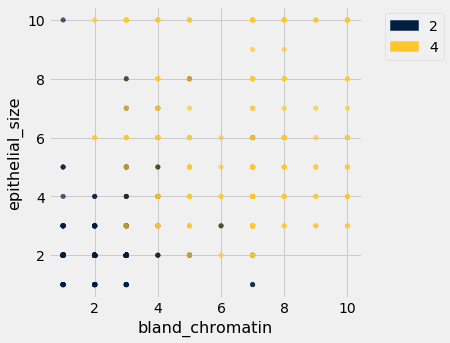

In [54]:
patients.scatter('bland_chromatin', 'epithelial_size', colors ='class')

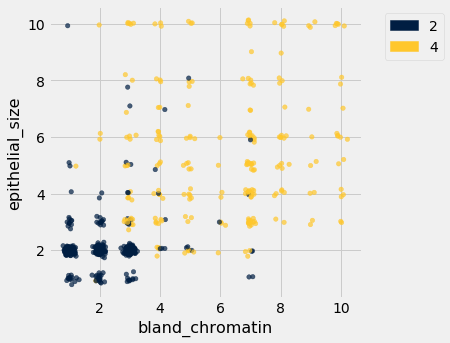

In [55]:
def randomize_columns(a):
    return a + np.random.normal(0.0,0.09,size=len(a))

jittered = Table().with_columns([
    'bland_chromatin', 
    randomize_columns(patients.column('bland_chromatin')),
    'epithelial_size', 
    randomize_columns(patients.column('epithelial_size')),
    'class',
    patients.column('class')
])

jittered.scatter('bland_chromatin', 'epithelial_size', colors ='class')

In [56]:
def distance(pt1, pt2):
    return np.sqrt(sum((pt1 - pt2) ** 2))
    
def row_distance(row1,row2):
    return distance( np.array(row1),  np.array(row2))

In [57]:
attributes = patients.drop('class')
attributes.show(3)

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [58]:
row_distance(attributes.row(0),attributes.row(1))

11.874342087037917

In [59]:
row_distance(attributes.row(0),attributes.row(2))

2.23606797749979

In [60]:
row_distance(attributes.row(0),attributes.row(0))

0.0

In [67]:
def distances(training,example):
    dists = []
    attributes = training.drop('class')
    for row in attributes.rows:
        dist = row_distance(row, example)
        dists.append(dist)
    return training.with_column('distance',dists)

In [68]:
def closest(training, example, k):
    return distances(training, example).sort('distance').take(np.arange(k))

In [79]:
patients.take(9)

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
4,2,1,1,2,1,2,1,1,2


In [80]:
example = patients.drop('class').row(9)
example

Row(thickness=4, size_uniformity=2, shape_uniformity=1, adhesion=1, epithelial_size=2, bare_nuclei=1, bland_chromatin=2, normal_nucleoli=1, mitosis=1)

In [81]:
closest(patients.exclude(9), example, 5)

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class,distance
4,1,1,1,2,1,2,1,1,2,1
4,1,1,1,2,1,2,1,1,2,1
4,2,2,1,2,1,2,1,1,2,1
4,2,1,1,2,1,1,1,1,2,1
4,1,1,1,2,1,2,1,1,2,1


In [87]:
def majority_class(neighbors):
    return neighbors.group('class').sort('count', descending=True).column('class').item(0)

def classify(training, example, k):
    nearest_neighbors = closest(training, example, k)
    return majority_class(nearest_neighbors)

In [88]:
classify(patients.exclude(9), example, 5)

2

In [91]:
patients.num_rows

683

In [102]:
shuffled = patients.sample(with_replacement=False)

trainset = shuffled.take(range(0,342))
testset = shuffled.take(range(342, 683))

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('class')
    numcorrect = 0
    for i in range(test.num_rows):
        test_patient = test_attributes.row(i)
        c = classify(training, test_patient, k)
        if c == test.column('class').item(i):
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

In [104]:
evaluate_accuracy(trainset,testset,5)

0.9648093841642229

In [106]:
evaluate_accuracy(trainset,testset,1)

0.9560117302052786

In [108]:
evaluate_accuracy(trainset,trainset,5)

0.97953216374269

In [109]:
evaluate_accuracy(trainset,trainset,1)

1.0

In [137]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)

def standardize(t):
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

def show_closest(t, point):
    near = closest(t, point, 1).row(0)
    t.scatter(0,1,colors='class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)],color='k',lw=2)

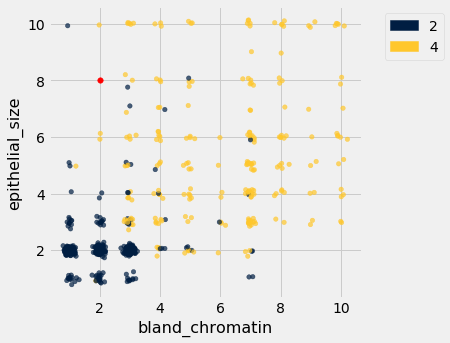

In [138]:
patients_ce = jittered.select('bland_chromatin', 'epithelial_size', 'class')
patients_ce.scatter('bland_chromatin', 'epithelial_size', colors=2)
plt.scatter(2,8,color='red',s=30)

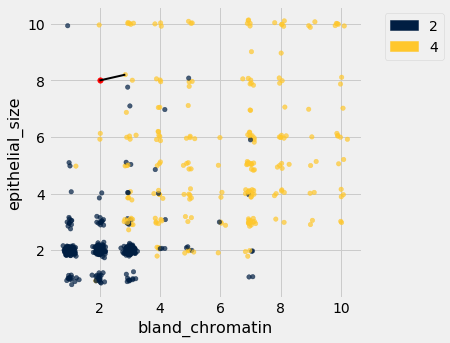

In [139]:
show_closest(patients_ce, np.array([2,8]))

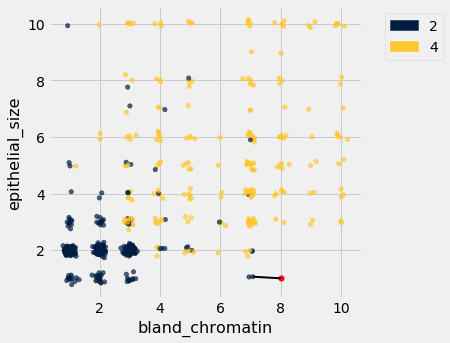

In [140]:
show_closest(patients_ce, np.array([8,1]))

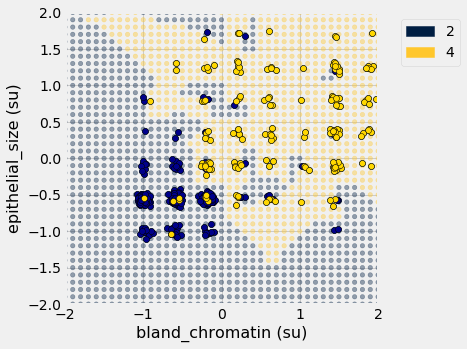

In [156]:
def decision_boundary(t,k):
    t_su = standardize(t.drop('class')).with_column('class', t.column('class'))
    decisions = Table(t_su.labels)
    for x in np.arange(-2,2.1,0.1):
        for y in np.arange(-2, 2.1,0.1):
            predicted = classify(t_su,np.array([x,y]),k)
            decisions.append([x,y,predicted])
    decisions.scatter(0,1,colors='class',alpha=0.4)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.scatter(t_su.column(0),t_su.column(1), edgecolor='k')
    t_su_0 = t_su.where('class',2)
    t_su_1 = t_su.where('class',4)
    plt.scatter(t_su_0.column(0),t_su_0.column(1), c='darkblue', edgecolor='k')
    plt.scatter(t_su_1.column(0),t_su_1.column(1), c='gold', edgecolor='k')

decision_boundary(jittered, 1)

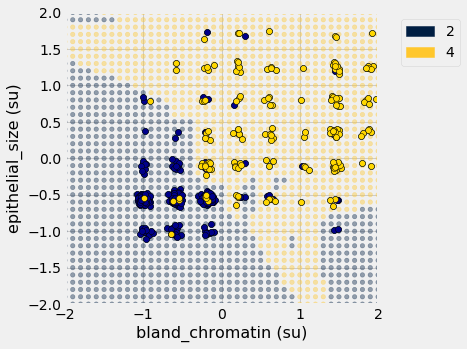

In [157]:
decision_boundary(jittered, 5)